Riding the Wave

Numerical schemes for hyperbolic PDEs

Red Light!

Let's explore behavior for a moving shock wave. Imagine a busy road and a red light at x=4. Cars accumulate quickly in the front where max allowed density of cars between x=3 and x=4. Incoming traffic is 50% of the max allowed density.

mathematically we have:

\begin{equation}\rho(x,0) = \left\{ \begin{array}{cc}
0.5 \rho_{\rm max} & 0 \leq x < 3  \\
\rho_{\rm max} & 3 \leq x \leq 4 \\ \end{array} \right.\end{equation}

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
def rho_red_light(nx,rho_max, rho_in):
    """Compoutes red light initial conditions with shock"""
    
    rho = rho_max*numpy.ones(nx)
    rho[:(nx-1)*3./4.] = rho_in
    return rho

In [3]:
#Iinitial Conditinos and Params

nx = 81
nt = 30
dx = 4.0/(nx-1)

rho_in = 5.
rho_max = 10.

u_max = 1.

x = numpy.linspace(0,4,nx)

rho = rho_red_light(nx,rho_max, rho_in)

//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


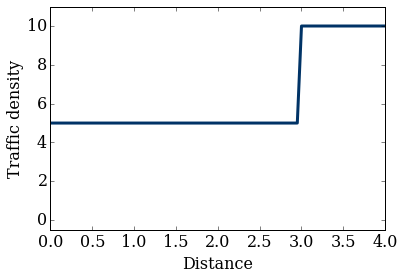

In [4]:
pyplot.plot(x,rho,color='#003366', ls='-', lw=3)
pyplot.ylabel('Traffic density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5, 11.);

The question to solve is how will cars accumulate at the red light?

We will solve using the following shemes:
-Lax-Friedrichs
-Lax-Wendroff
-MacCormack

The wave speed $u_{wave}$ is $ -1 $ for $ \rho = \rho_{max}/2$ making all velocities negative. We should see solution moving left

In [5]:
def computeF(u_max, rho_max, rho):
    """Computes Flux F=V*rho"""
    
    return u_max*rho*(1-rho/rho_max)

In [6]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation


ImportError: No module named 'JSAnimation'

In [7]:
def animate(data):
    x=numpy.linspace(0,4,nx)
    y=data
    line.set(x,y)
    return line

Lax-Friedrichs Scheme

Conservation Law for vehicle traffic

$$\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0$$

F is the traffic flux 

$$F = \rho u_{max} \left(1-\frac{\rho}{\rho_{max}} \right)$$

In the time variable the natural choice is always forward difference:

$$\frac{\partial \rho}{\partial t} = \frac{1}{\Delta t}(\rho_i^{n+1} - \rho_i^n)$$

In order to get second-order accuracy in space use a central difference

$$\frac{\partial F}{\partial x} = \frac{1}{2\Delta x}(F_{i+1} - F_{i-1})$$

BUT the forward time central space discretization is unstable! The Lax Friedrichs scheme is to replace the solution at $\rho_i^n$ by the average of the values at the neighboring grid points.

$$\frac{\rho_i^{n+1} -\frac{1}{2}(\rho_{i+1}^n + \rho_{i-1}^n)}{\Delta t} = \frac{F_{i+1}^n - F_{i-1}^n}{2 \Delta x}$$

To implement the scheme in the code we need to isolate the next step:

$$\rho_i^{n+1} = \frac{1}{2}(\rho_{i+1}^n + \rho_{i-1}^n) - \frac{\Delta t}{2\Delta x}(F_{i+1}^n - F_{i-1}^n)$$



In [8]:
def laxfriedrichs(rho, nt,dt,dx,rho_max,u_max):
    #Initialize the results array
    rho_n = numpy.zeros((nt,len(rho)))
    rho_n[:,:] = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_n[t,1:-1] = .5*(rho[2:]+rho[:-2]) - dt/(2*dx)*(F[2:]-F[:-2])
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
    return rho_n

In [9]:
#We will try first with CFL=1

sigma = 1.0
dt = sigma*dx/u_max

rho = rho_red_light(nx,rho_max, rho_in)
rho_n = laxfriedrichs(rho, nt, dt, dx,rho_max,u_max)


//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [10]:
rho_n.shape

(30, 81)

TypeError: set() takes 1 positional argument but 3 were given

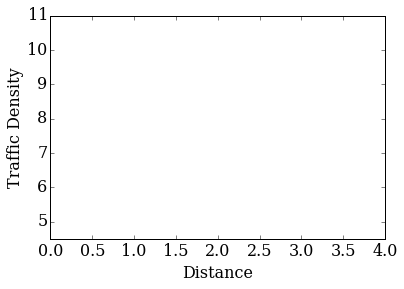

In [12]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4), ylim=(4.5,11),xlabel=('Distance'), ylabel=('Traffic Density'));
line, = ax.plot([],[], color='#003366', lw=2);

anim = animation.FuncAnimation(fig,animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

Think



In [13]:
#CFL = 0.5

sigma = 0.5
dt = sigma*dx/u_max

rho = rho_red_light(nx,rho_max, rho_in)
rho_n = laxfriedrichs(rho, nt, dt, dx,rho_max,u_max)



//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [14]:
anim = animation.FuncAnimation(fig,animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

TypeError: set() takes 1 positional argument but 3 were given

Dig Deeper

